# Feature selection

* Statistical Approaches
* Selection using models
* Greedy algorithms
* PCA
* L1 regularuzation

## Statistical approaches 

**Variance** -- we get rid of features with a small variance, we assume that they contain little information.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)


x_data_generated, y_data_generated = make_classification()

x_data_generated.shape

(100, 20)

In [26]:
x_data_generated_new = VarianceThreshold(.9).fit_transform(x_data_generated)

In [27]:
cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, scoring='neg_log_loss').mean()

-0.24508563450822315

In [28]:
cross_val_score(LogisticRegression(), x_data_generated_new, y_data_generated, scoring='neg_log_loss').mean()

-0.2282048253418604

**Statistical criteria** -- select several features with the highest values of the statistical criterion.

*F-value between label/feature for classification tasks*

In [29]:
from sklearn.feature_selection import SelectKBest, f_classif

x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(x_data_generated, y_data_generated)

In [30]:
cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, scoring='neg_log_loss').mean()

-0.24508563450822315

In [31]:
cross_val_score(LogisticRegression(), x_data_kbest, y_data_generated, scoring='neg_log_loss').mean()

-0.22964728380409727

*T-statistics*

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

where $\mu$, $\sigma$, $n$ mean, variance and the number of objects of each class of classes respectively.

In [55]:
t = []
for feature in range(x_data_generated.shape[1]):
    
    m_plus = np.mean(x_data_generated[y_data_generated == np.unique(y_data_generated)[0]][:, feature])
    n_plus = x_data_generated[y_data_generated == np.unique(y_data_generated)[0]][:, feature].shape[0]
    sigma_plus = np.var(x_data_generated[y_data_generated == np.unique(y_data_generated)[0]][:, feature])
    
    m_min = np.mean(x_data_generated[y_data_generated == np.unique(y_data_generated)[1]][:, feature])
    n_min = x_data_generated[y_data_generated == np.unique(y_data_generated)[1]][:, feature].shape[0]
    sigma_min = np.var(x_data_generated[y_data_generated == np.unique(y_data_generated)[1]][:, feature])
    
    t.append(np.abs(m_plus-m_min) / np.sqrt((n_plus * sigma_plus ** 2 + n_min * sigma_min ** 2 ) / (n_plus + n_min)))

In [56]:
idx = np.argpartition(t, -10)[-10:]

In [57]:
x_data_generated_new = x_data_generated[:, idx]

In [58]:
%%time
cross_val_score(LogisticRegression(), x_data_generated_new, y_data_generated, scoring='neg_log_loss').mean()

CPU times: user 43.1 ms, sys: 6.32 ms, total: 49.4 ms
Wall time: 45.6 ms


-0.2611774844512248

**Correlation** -- exclude features with low correlation with the target variable

In [26]:
x_data_generated, y_data_generated = make_classification(n_samples=100, n_features=10, n_informative=5, n_redundant=5, n_repeated=0)

df_num = pd.DataFrame(np.hstack((x_data_generated, y_data_generated.reshape(-1,1))))

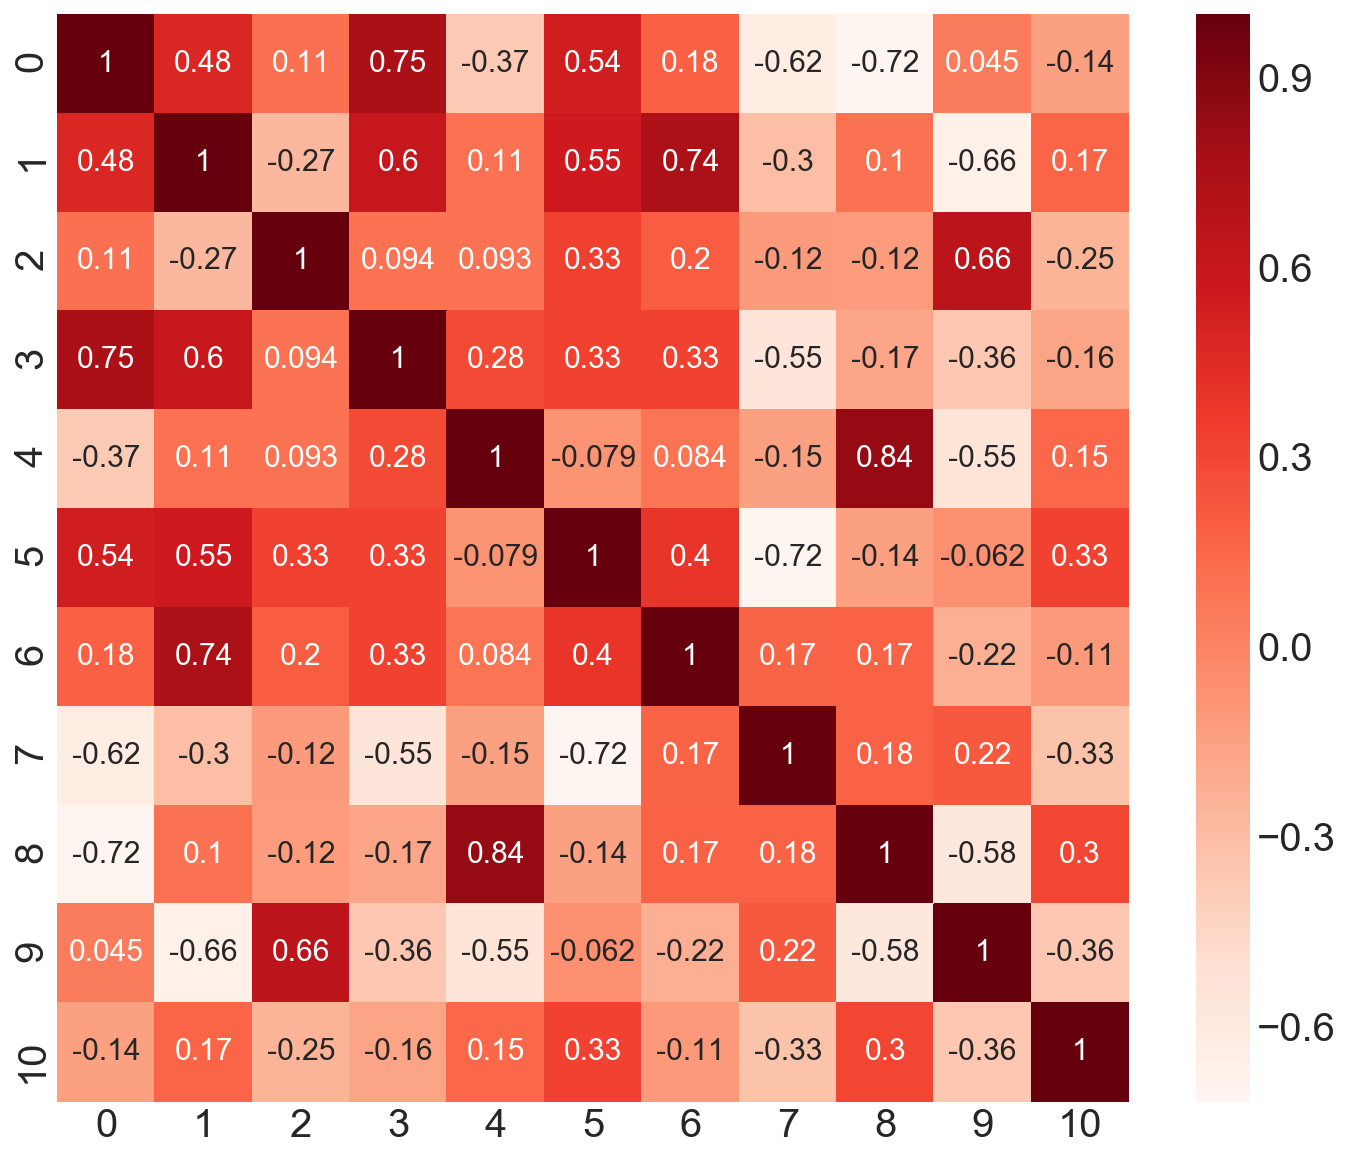

In [27]:
plt.figure(figsize=(12,10))
cor = df_num.corr()
sns.heatmap(np.round(cor, 3), annot=True, cmap=plt.cm.Reds, annot_kws={"size": 15})
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.show()

In [30]:
#Correlation with output variable
cor_target = abs(cor[10])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.15]

In [32]:
relevant_features.index

Int64Index([1, 2, 3, 4, 5, 7, 8, 9, 10], dtype='int64')

## Selection using models

Some algorithms predict the importance of features (*RandomForestClassifier, LogisticRegression, Linear Regrassion*). We will use this result to select meaningfull features. 
If in function *SelectFromModel* we will not mention additional paramenetrs, it gets rid of signs whose importance is less than average.

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

x_data_generated, y_data_generated = make_classification()


pipe = make_pipeline(SelectFromModel(estimator=RandomForestClassifier()),
                     LogisticRegression())

lr = LogisticRegression()
rf = RandomForestClassifier()

print(cross_val_score(lr, x_data_generated, y_data_generated, scoring='neg_log_loss').mean())
print(cross_val_score(rf, x_data_generated, y_data_generated, scoring='neg_log_loss').mean())
print(cross_val_score(pipe, x_data_generated, y_data_generated, scoring='neg_log_loss').mean())

-0.24815277522305262
-0.3191088293091719
-0.19581196120086128


## Greedy algorithms

[ExhaustiveFeatureSelector](http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/) -- compares the results of models on various subsets of features


[SequentialFeatureSelector](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/) -- fix a small number N, iterate over all combinations of N features, select the best combination, then iterate through the combinations of N + 1 features so that the previous best combination of features is fixed, and only a new features changes. Thus, it is possible to sort through until we hit the maximum allowable number of features or until the quality of the model ceases to grow significantly.

In [7]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit_transform(x_data_generated)

selector = SequentialFeatureSelector(LogisticRegression(), scoring='neg_log_loss', verbose=2, k_features=3, forward=False, n_jobs=-1)

In [10]:
selector.fit(x_data_generated, y_data_generated)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.1s finished

[2020-05-15 22:47:10] Features: 19/3 -- score: -0.23277232057157743[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.4s finished

[2020-05-15 22:47:11] Features: 18/3 -- score: -0.22075563679567134[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.5s finished

[2020-05-15 22:47:11] Features: 17/3 -- score: -0.21037757711897692[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.4s finished

[2020-05-15 22:47:12] Features: 16/3 -- score

SequentialFeatureSelector(clone_estimator=True, cv=5,
                          estimator=LogisticRegression(C=1.0, class_weight=None,
                                                       dual=False,
                                                       fit_intercept=True,
                                                       intercept_scaling=1,
                                                       l1_ratio=None,
                                                       max_iter=100,
                                                       multi_class='auto',
                                                       n_jobs=None,
                                                       penalty='l2',
                                                       random_state=None,
                                                       solver='lbfgs',
                                                       tol=0.0001, verbose=0,
                                                       warm_start=False),

In [11]:
selector.k_feature_idx_

(1, 13, 18)

## PCA and L1-regularization

Two other ways of feature selection are PCA and L1-regularization. L1-regularization vanishes coefficients of not important features, while PCA turns features into a new space, then we can save features containing the maximum level of data variance (usually 90%).